# My own BackPropagation Implementation

In [1]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import random

#let's define some basic functions. Even though I am not using anything besides sigmoid function
#, I have defined the softmax and the derivative 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    return sigmoid(x)(1-sigmoid(x))


def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def derivative(f):
    if f == sigmoid:
        return sigmoid_derivative

# My backpropagation for MLP training

In [43]:
from math import sqrt
import numpy as np
import random

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)(1-sigmoid(x))


def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def derivative(f):
    if f == sigmoid:
        return sigmoid_derivative

class bornaMLP:
    def __init__(self,layers_sizes, activations , batch_size=10, eta=0.05, epocs=1000, update='online', minibatch_percentage=0.1, verbose=True):
        self.minibatch_percentage = minibatch_percentage
        self.update=update# other values batch, mini-batch
        self.errors=[]
        self.eta=eta
        self.epocs=epocs
        self.activations=activations
        self.num_layers = len(layers_sizes)
        self.layers_sizes = layers_sizes
        self.verbose= verbose
        self.W , self.B= self.generate_random_weights()
        
    def generate_random_weights(self):
        W={}
        B={}
        for i in range(len(self.layers_sizes)-1):
            upper = 4*sqrt(6)/sqrt(self.layers_sizes[i]+self.layers_sizes[i+1])
            #weight also includes biases
            B[str(i)+"-"+str(i+1)]=np.zeros(self.layers_sizes[i+1])
            W[str(i)+"-"+str(i+1)] = np.random.uniform(-upper,upper, self.layers_sizes[i:i+2])#np.ones( self.layers_sizes[i:i+2])
        return W,B
    
    def feed_forward(self,x): #feed forward
        x = np.array(x)
        ffr=[x]#Feed Forward Result
        for i in range(self.num_layers-1):
            w = self.W[str(i)+"-"+str(i+1)]
            b= self.B[str(i)+"-"+str(i+1)]
            y = self.activations[i](np.dot(x,w) +b ) #clculate the output of the layer
            x=y
            ffr.append(y)
        return ffr
    
    def _calc_error(self,X,Y):
        prediction = self.feed_forward(X)
        return .5*np.sum((Y-prediction[-1])**2)/(X.shape[0])
        
    def fit(self,X,Y):
        self.W , self.B= self.generate_random_weights()
        self.errors.append(self._calc_error(X,Y))
        X=np.array(X)
        Y=np.array(Y)
        for i in range(self.epocs):
            if not self.verbose:
                if i<10:
                    print ("epoc->",i+1)
                elif i<100 and i%10==0:
                    print ("epoc->",i)
                elif i<1000 and i%100==0:
                    print ("epoc->",i)
                elif i<10000 and i%1000==0:
                    print ("epoc->",i)
                elif i<100000 and i%10000==0:
                    print ("epoc->",i)
            
            if self.update == 'online':
                for j in range(X.shape[0]):
                    delta_W, delta_B = self.calc_weight_updates(X[j,:],Y[j])
                    self.update_weights(delta_W, delta_B)
            elif self.update == 'batch' or 'stochastic-mini-batch':
                if self.update == 'batch':
                    this_batch=X
                    this_batch_Y=Y
                elif self.update == 'stochastic-mini-batch': # let's create a mini batch
                    minibatch_indices = random.sample(range(X.shape[0]), int(X.shape[0]*self.minibatch_percentage))
                    this_batch=  X[minibatch_indices,:]
                    this_batch_Y=Y[minibatch_indices,:]
                    
                sum_delta_W={}
                sum_delta_B={}
                for j in range(this_batch.shape[0]):
                    delta_W, delta_B = self.calc_weight_updates(this_batch[j,:],this_batch_Y[j,:])
                    for k in delta_W.keys():#adding all the deltas at different layers to our sum
                        if k in sum_delta_W:
                            sum_delta_W[k] += delta_W[k]
                            sum_delta_B[k] += delta_B[k]
                        else:
                            sum_delta_W[k] = delta_W[k]
                            sum_delta_B[k] = delta_B[k]
					
                self.update_weights(sum_delta_W, sum_delta_B)
                
            self.errors.append(self._calc_error(X,Y))
                
    def update_weights(self,delta_W,delta_B):
        for i in range(self.num_layers-1): #going through layers
            index=str(i)+"-"+str(i+1)
            self.W[index] -= delta_W[index]
            self.B[index] -= delta_B[index]

    def predict(self,X):
        nn_output = self.feed_forward(X)
        labels = np.argmax(nn_output[-1],axis=1)
        return labels
        

    def calc_weight_updates(self,inputx,target):
        ffr = self.feed_forward(inputx)
        # https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/        
        #step1: output layer
        delta_W={}
        delta_B={}
        
        this_output = ffr[-1]
        previous_output = ffr[-2]

        this_delta = ((this_output - target)) * (this_output * (1-this_output))
        weight_chagnge = np.outer(previous_output , this_delta)
        
        delta_W[str(self.num_layers-2)+"-"+str(self.num_layers-1)] = self.eta * weight_chagnge
        delta_B[str(self.num_layers-2)+"-"+str(self.num_layers-1)] = self.eta *this_delta
        
        #step2: Hidden Layers
        for i in reversed(range(1,self.num_layers-1)): # Going through all the layers backwards
            next_layer_delta = this_delta
            
            hl_output = ffr[i]
            hl_input = ffr[i-1]
            hl_out_weights = self.W[str(i)+"-"+str(i+1)]
            
            this_delta =np.dot(hl_out_weights, next_layer_delta) * hl_output *(1-hl_output)
            weight_chagnge = np.outer(hl_input,this_delta)
            delta_W[str(i-1)+"-"+str(i)] = self.eta* weight_chagnge     
            delta_B[str(i-1)+"-"+str(i)] = self.eta* this_delta
            
        return delta_W, delta_B

# Tesing our MLP for small problems


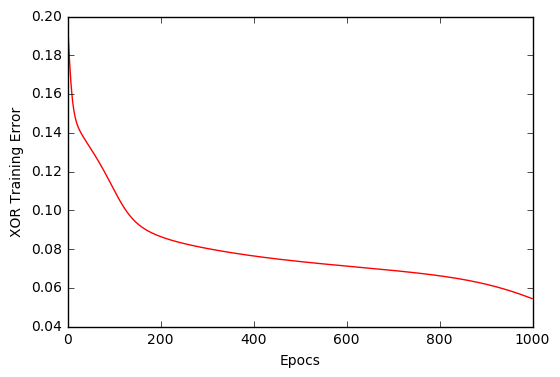

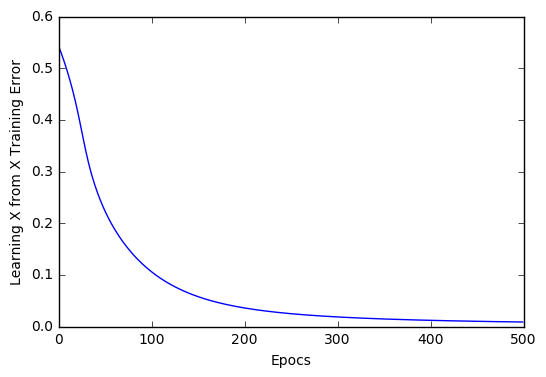

In [45]:

#XOR
mlp1= bornaMLP([3,5,5,2],activations=10*[sigmoid],epocs=1000,eta=0.1)
X=[[0,0,0],[1,0,1],[0,1,1],[1,1,1]]
Y=[[0,1],[1,1],[1,1],[0,1]]
mlp1.fit(X,Y)

plt.plot(range(len(mlp1.errors)), mlp1.errors,'r')
plt.xlabel("Epocs")
plt.ylabel("XOR Training Error")
plt.show()

# learning X from X
mlp2= bornaMLP([3,10,3],activations=10*[sigmoid],epocs=500,eta=0.1)
X=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
Y=X
mlp2.fit(X,Y)


plt.plot(range(len(mlp2.errors)), mlp2.errors)
plt.xlabel("Epocs")
plt.ylabel("Learning X from X Training Error")
plt.show()

